<a href="https://colab.research.google.com/github/Filquichante/Machina/blob/main/MachinaV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalisation avec une moyenne et un écart-type spécifiés
])

In [ ]:
# Download training data from open datasets.
training_data = datasets.Food101(
    root="data",
    split="train",
    download=True,
    transform=transform,
)

# Download test data from open datasets.
test_data = datasets.Food101(
    root="data",
    split="test",
    download=True,
    transform=transform,
)

100%|██████████| 4996278331/4996278331 [04:14<00:00, 19611861.18it/s]


Extracting data/food-101.tar.gz to data


In [ ]:
batch_size = 16

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([16, 3, 512, 512])
Shape of y: torch.Size([16]) torch.int64


Shape of X [N, C, H, W]: torch.Size([16, 3, 512, 512])
Shape of y: torch.Size([16]) torch.int64


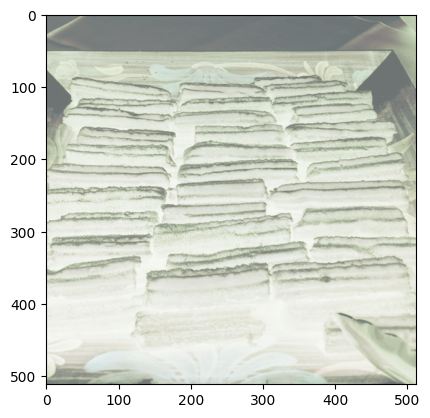

In [ ]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    plt.imshow(X[0][0],cmap="Blues",alpha=0.3)
    plt.imshow(X[0][1],cmap="Reds",alpha=0.3)
    plt.imshow(X[0][2],cmap="Greens",alpha=0.3)
    break

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def convolution(w_input,h_input,kernel,stride,padding):
  w_output = 1+(w_input+2*padding-kernel)/stride
  h_output = 1+(h_input+2*padding-kernel)/stride
  return w_output, h_output

In [ ]:
convolution(31,31,4,1,1)

(30.0, 30.0)

In [ ]:
convolution(124,124,4,2,3)

(64.0, 64.0)

In [ ]:
10*15*15

2250

In [ ]:
class NeuralNetworkCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,10,10,stride=2,padding=1) # 3x512x512  =>  32*253*253
        self.conv2 = nn.Conv2d(10,10,10,stride=1,padding=1)# 32*253*253  =>  32*248*248
        self.act1 = nn.ReLU()
        self.drop = nn.Dropout(0.1)
        self.pool1 = nn.MaxPool2d(2)                      #32*248*248 => 32*124*124

        self.conv3 = nn.Conv2d(10,10,4,stride=2,padding=3)#32*124*124  =>  32*62*62
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(4)                      #32x62x62  =>  32*31*31

        #self.conv4 = nn.Conv2d(10,10,4,stride=1,padding=1) #32*31*31 => 32*30*30
        #self.act3 = nn.ReLU()
        #self.pool3 = nn.MaxPool2d(2)  #32*15*15

        self.flat = nn.Flatten(start_dim=1)               #4*10*15*15=>  4 * 2250

        self.ll1 = nn.Linear(2250,512)  #4 * 2250 => 4*512
        self.act4 = nn.ReLU()
        self.ll2 = nn.Linear(512,101)    #4 * 512 =>  4 * 101

    def forward(self, x):
        x = self.pool1(self.drop(self.act1(self.conv2(self.conv1(x)))))
        x = self.pool2(self.act2(self.conv3(x)))
        #x = self.pool3(self.act3(self.conv4(x)))
        x = self.flat(x)
        logits = self.ll2(self.act4(self.ll1(x)))
        return logits

model = NeuralNetworkCNN().to(device)
print(model)

NeuralNetworkCNN(
  (conv1): Conv2d(3, 10, kernel_size=(10, 10), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(10, 10), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (drop): Dropout(p=0.1, inplace=False)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (ll1): Linear(in_features=2250, out_features=512, bias=True)
  (act4): ReLU()
  (ll2): Linear(in_features=512, out_features=101, bias=True)
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    n = 0
    for batch, (X, y) in enumerate(dataloader):
        n+=1
        if n >= 10:
            break
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #if batch % 100 == 0:
        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    n = 0
    with torch.no_grad():
        for X, y in dataloader:
            n+=1
            if n>=10:
                break
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.705135  [   16/75750]
loss: 3.847167  [   32/75750]
loss: 1.569429  [   48/75750]
loss: 0.051066  [   64/75750]
loss: 0.000081  [   80/75750]
loss: 0.000000  [   96/75750]
loss: 0.000000  [  112/75750]
loss: 0.000000  [  128/75750]
loss: 0.000000  [  144/75750]
Test Error: 
 Accuracy: 0.6%, Avg loss: 0.000000 

Epoch 2
-------------------------------
loss: 0.000000  [   16/75750]
loss: 0.000000  [   32/75750]
loss: 0.000000  [   48/75750]
loss: 0.000000  [   64/75750]
loss: 0.000000  [   80/75750]
loss: 0.000000  [   96/75750]
loss: 0.000000  [  112/75750]
loss: 0.000000  [  128/75750]
loss: 0.000000  [  144/75750]
Test Error: 
 Accuracy: 0.6%, Avg loss: 0.000000 

Epoch 3
-------------------------------
loss: 0.000000  [   16/75750]
loss: 0.000000  [   32/75750]
loss: 0.000000  [   48/75750]
loss: 0.000000  [   64/75750]
loss: 0.000000  [   80/75750]
loss: 0.000000  [   96/75750]
loss: 0.000000  [  112/75750]
loss: 0.000000  [  128/75750